In [88]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-and-burnout-in-the-workplace/mental_health_workplace_survey.csv


In [89]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression  

sns.set_style("whitegrid")

In [90]:
file_path = "/kaggle/input/mental-health-and-burnout-in-the-workplace/mental_health_workplace_survey.csv"
df = pd.read_csv(file_path)

In [91]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()


df.replace(['', 'na', 'n/a', 'none', 'unknown'], np.nan, inplace=True)

print("\nMissing values per column:\n")
print(df.isna().sum())


numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Filled missing in {col} with median = {median_val}")


cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)
    print(f"Filled missing in {col} with mode = '{mode_val}'")


Missing values per column:

EmployeeID                0
Age                       0
Gender                    0
Country                   0
JobRole                   0
Department                0
YearsAtCompany            0
WorkHoursPerWeek          0
RemoteWork                0
BurnoutLevel              0
JobSatisfaction           0
StressLevel               0
ProductivityScore         0
SleepHours                0
PhysicalActivityHrs       0
CommuteTime               0
HasMentalHealthSupport    0
ManagerSupportScore       0
HasTherapyAccess          0
MentalHealthDaysOff       0
SalaryRange               0
WorkLifeBalanceScore      0
TeamSize                  0
CareerGrowthScore         0
BurnoutRisk               0
dtype: int64
Filled missing in EmployeeID with median = 2500.5
Filled missing in Age with median = 41.0
Filled missing in YearsAtCompany with median = 10.0
Filled missing in WorkHoursPerWeek with median = 45.0
Filled missing in BurnoutLevel with median = 5.48
Filled miss

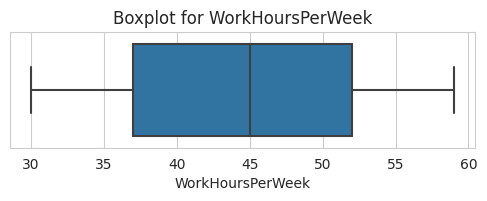

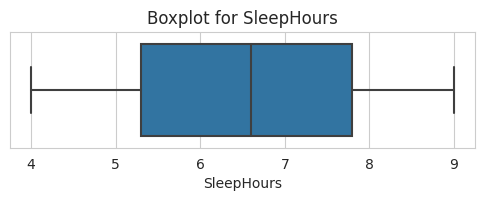

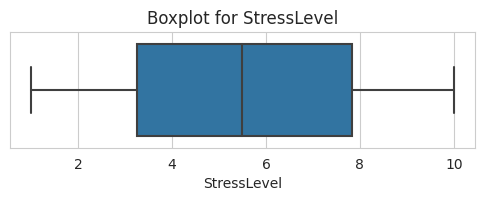

In [92]:

features = ['WorkHoursPerWeek', 'SleepHours', 'StressLevel']
for col in features:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot for {col}")
    plt.show()
     

In [93]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = df.shape[0]
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    after = df.shape[0]
    print(f"{before - after} outliers removed from '{col}'")
    return df

for col in numeric_cols:
    df = remove_outliers_iqr(df, col)


0 outliers removed from 'EmployeeID'
0 outliers removed from 'Age'
0 outliers removed from 'YearsAtCompany'
0 outliers removed from 'WorkHoursPerWeek'
0 outliers removed from 'BurnoutLevel'
0 outliers removed from 'JobSatisfaction'
0 outliers removed from 'StressLevel'
0 outliers removed from 'ProductivityScore'
0 outliers removed from 'SleepHours'
0 outliers removed from 'PhysicalActivityHrs'
0 outliers removed from 'CommuteTime'
0 outliers removed from 'ManagerSupportScore'
0 outliers removed from 'MentalHealthDaysOff'
0 outliers removed from 'WorkLifeBalanceScore'
0 outliers removed from 'TeamSize'
0 outliers removed from 'CareerGrowthScore'
0 outliers removed from 'BurnoutRisk'


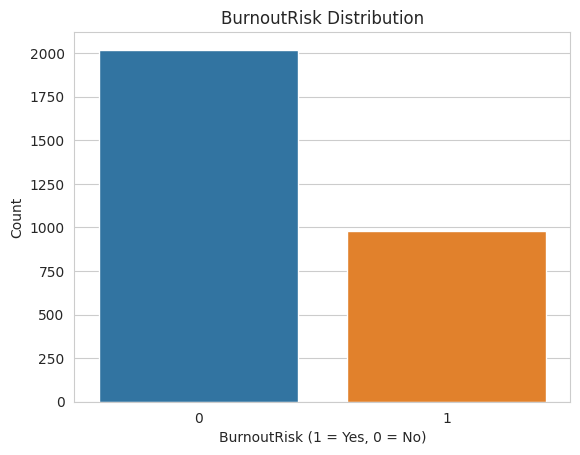

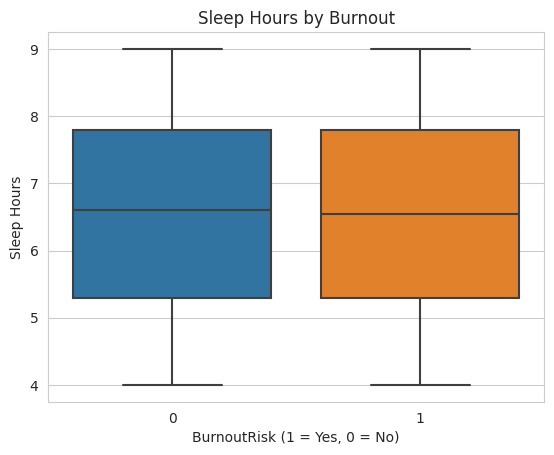

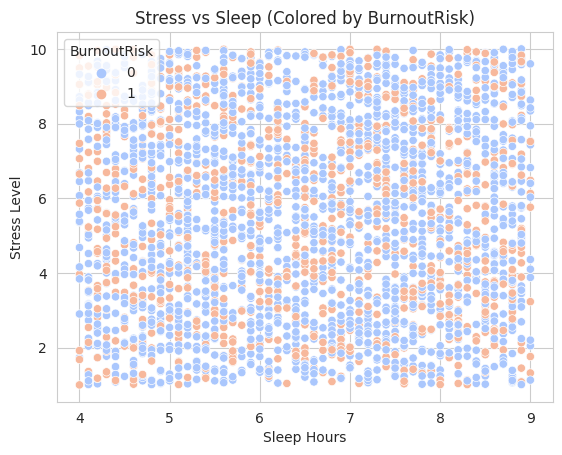

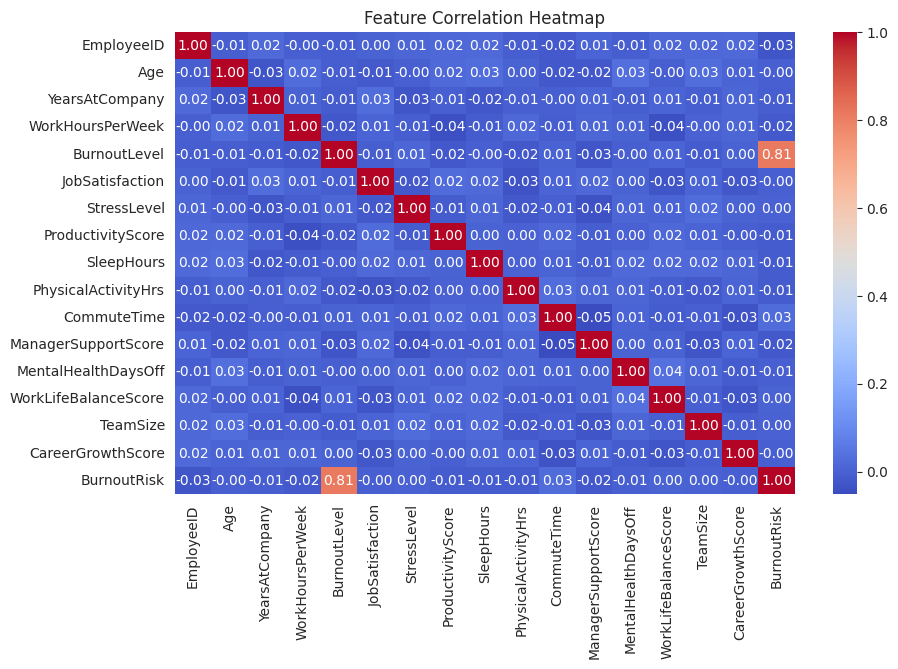

In [94]:
sns.countplot(x='BurnoutRisk', data=df)
plt.title("BurnoutRisk Distribution")
plt.xlabel("BurnoutRisk (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

sns.boxplot(x='BurnoutRisk', y='SleepHours', data=df)
plt.title("Sleep Hours by Burnout")
plt.xlabel("BurnoutRisk (1 = Yes, 0 = No)")
plt.ylabel("Sleep Hours")
plt.show()

sns.scatterplot(x='SleepHours', y='StressLevel', hue='BurnoutRisk', data=df, palette='coolwarm')
plt.title("Stress vs Sleep (Colored by BurnoutRisk)")
plt.xlabel("Sleep Hours")
plt.ylabel("Stress Level")
plt.legend(title="BurnoutRisk")
plt.show()

plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=['int64', 'float64'])# Only select numeric columns
# Plot heatmap of correlations
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [95]:
df.to_csv("/kaggle/working/cleaned_mental_health_survey_day1.csv", index=False)
print("\nCleaned data saved")


Cleaned data saved


In [96]:
##interactive features..
df['workStress'] = df['StressLevel'] * df['WorkHoursPerWeek']
df['sleepStress'] = df['StressLevel'] * df['SleepHours']

In [97]:
#selecting 5 best corelations...
corrs = df.corr(numeric_only=True)
corrList = corrs['StressLevel'].abs().sort_values(ascending=False)
topCorr = corrList.drop('StressLevel').head(5).index.tolist()

#feature selection...
numCols = df.select_dtypes(include=[np.number]).drop(columns=['StressLevel']).columns
miVals = mutual_info_regression(df[numCols], df['StressLevel'])
miList = pd.Series(miVals, index=numCols)
topMi = miList.sort_values(ascending=False).head(5).index.tolist()

In [98]:
extraFeats = ['workStress', 'sleepStress']
numFeats = list(set(topCorr + topMi + extraFeats))

#catogorical...
catCols = df.select_dtypes(include=['object', 'category']).columns.tolist()
ordCols = ['EducationLevel'] if 'EducationLevel' in catCols else []
nomCols = [c for c in catCols if c not in ordCols]

#final...
preproc = ColumnTransformer([
    ('scale', StandardScaler(), numFeats),
    ('ord', OrdinalEncoder(), ordCols),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False), nomCols)
])


#training the test split

allFeats = numFeats + ordCols + nomCols
X = df[allFeats]
y = df['StressLevel']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=69)


In [99]:
regModels = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}

# training and checking the results...
results = {}
for m in regModels:
  pipe = Pipeline([('prep', preproc),('reg', regModels[m])])
  pipe.fit(Xtrain, ytrain)
  preds = pipe.predict(Xtest)
  r2 = r2_score(ytest, preds)
  mse = mean_squared_error(ytest, preds)
  results[m] = {'R2': round(r2,4), 'MSE': round(mse,4)}



In [100]:
# printing...
print('Test Set Results:')
for m in results:
 print(m + ': R2 =', results[m]['R2'], ', MSE =', results[m]['MSE'])
    
best = max(results.items(), key=lambda x: x[1]['R2'])
print(" ")
print('Best model:', best[0], '(R2:', best[1]['R2'], ', MSE:', best[1]['MSE'], ')')

Test Set Results:
Linear: R2 = 0.9631 , MSE = 0.2593
Ridge: R2 = 0.9631 , MSE = 0.2592
Lasso: R2 = 0.958 , MSE = 0.2949
 
Best model: Linear (R2: 0.9631 , MSE: 0.2593 )
